In [1]:
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
import random
import nltk
from nltk.collocations import *
from nltk.tokenize import word_tokenize
import scipy.stats as stats
from scipy.stats import binom
import scipy
import itertools
from collections import Counter
from collections import defaultdict
import functools
%matplotlib inline

bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()

In [223]:
###This set of code finds TRE associations by an analogy of bigrams###
#class bigram_analysis():
    
    #def __init__(self, path):
    #    self.path = path
        
#read in a csv with a single column, split to divide '# of hits' from 'TRE code description', filter out TREs with < 2 hits
def read_in(filepath):
    dfs1 = pd.read_csv(filepath, engine='python', sep=None, header=None)
    dfs1.columns = ['count','rawcode']
    dfs1 = dfs1.loc[dfs1['count'] > 2]
    return dfs1

#retrieve just the numeric code for the TRE (ignoring forward or reverse orientation)
def extract_code(df):
    toparse = df['rawcode'].tolist()
    code = []
    for s in toparse:
        singlecode = [c for c in s if not c.isupper()]
        jcode = ''.join(singlecode)
        code.append(jcode)
    df['code'] = code
    df['code'] = df['code'].str.replace('r', ' ')
    df['code'] = df['code'].str.replace('f', ' ')
    return df

#zips together all possible unique bigrams within a sequence with their respective # of hits
def extract_weighted_bigram_list(weighted_list):
    weighted_bigram_list = []
    for t in weighted_list:
        c = list(itertools.combinations(t[0], 2))
        nn = list(itertools.repeat(t[1], len(c)))
        d = dict(zip(c, nn))
        weighted_bigram_list.append(d)
    return weighted_bigram_list

#roundabout way of getting this; generate all possible bigrams, pull out elements, flatten to dict
def get_monofreq_from_commalist(comma_list):
    tuple_list = []
    for l in comma_list:
        c = list(itertools.combinations(l, 2))
        tuple_list.append(c)
    tmono = []
    for l in tuple_list:
        for e in l:
            tmono.append(list(e))
    monofreq = dict(Counter(itertools.chain(*tmono)))
    return monofreq

#???
def get_bifreq_from_commalist(comma_list):
    tuple_list = []
    for l in comma_list:
        c = list(itertools.combinations(l, 2))
        tuple_list.append(c)
    bifreq = dict(Counter(itertools.chain(*tuple_list)))
    return bifreq

def generate_weighted_contingencystats(t2_df):
    ###Expected Values generated from Monogram Frequencies###
    t2_df['w_eab'] = np.where(t2_df['unigram_one_x'] != t2_df['unigram_two'],
                            ((t2_df.w_monogram_freq_x/t2_df.w_nfiller)*(t2_df.w_monogram_freq_y/t2_df.w_nfiller)*2*t2_df.w_bigram_freq.sum()),
                            ((t2_df.w_monogram_freq_x/t2_df.w_nfiller)*(t2_df.w_monogram_freq_y/t2_df.w_nfiller)*t2_df.w_bigram_freq.sum()))
    t2_df['w_oab'] = t2_df.w_bigram_freq
    t2_df['w_pmi'] = np.log2(t2_df.w_oab/t2_df.w_eab)
    return t2_df

def remove_weighted_permutations(dic):
    r = sum((Counter({frozenset(k): sum(v)}) for k, v in dic.items()), Counter())
    return r

def extract_weighted_bifreq(weighted_bigram_list):
    w_bifreq = defaultdict(list)  
    for d in weighted_bigram_list:
        for k, v in d.items():
            w_bifreq[k].append(v)
    return w_bifreq

def extract_weighted_mono_freq(weighted_bigram_list):
    mono_dict = defaultdict(list) 
    for d in weighted_bigram_list:
        for k, v in d.items():
            if len(tuple(k)) == 2:
                mono_dict[tuple(k)[0]].append(v)
                mono_dict[tuple(k)[1]].append(v)
            if len(tuple(k)) < 2:
                mono_dict[tuple(k)[0]].append(v)
                mono_dict[tuple(k)[0]].append(v)
    r = dict((k, sum(v)) for k, v in mono_dict.items())
    return r

def calculate_bigram_statistics(comma_list, weighted_bigram_list):
    bifreq = get_bifreq_from_commalist(comma_list)
    monofreq = get_monofreq_from_commalist(comma_list)

    ###Setup Base Dataframe###
    #bistats = pd.DataFrame(list(remove_permutations(bifreq).items()), columns=['bigram', 'bigram_freq'])
    bistats = pd.DataFrame(list(remove_weighted_permutations(extract_weighted_bifreq(weighted_bigram_list)).items()),
                             columns=['bigram', 'w_bigram_freq'])
    #bistats = pd.merge(bistats, w_bistats, on='bigram', how='inner')
    bistats['bigram']= [list(x) for x in bistats.bigram]
    for e in bistats['bigram']:
        if len(e) == 1:
            e.append(e[0])
    bistats['unigram_one'] = [e[0] for e in bistats['bigram']]
    bistats['unigram_two'] = [e[1] for e in bistats['bigram']]

    ###Calc weighted monograms###
    w_monostats = pd.DataFrame(list(extract_weighted_mono_freq(weighted_bigram_list).items()), 
                               columns=['unigram', 'w_monogram_freq'])
    bistats = pd.merge(bistats, w_monostats, left_on='unigram_one', right_on='unigram', how='inner')
    bistats = pd.merge(bistats, w_monostats, left_on='unigram_two', right_on='unigram', how='inner')
    del bistats['unigram_x']
    del bistats['unigram_y']
    bistats['w_nfiller'] = w_monostats['w_monogram_freq'].sum()

    #expected association of bigram AB based on monogram frequency
    bistats['w_eab'] = np.where(bistats['unigram_one'] != bistats['unigram_two'],
                            ((bistats.w_monogram_freq_x/bistats.w_nfiller)*(bistats.w_monogram_freq_y/bistats.w_nfiller)*2*bistats.w_bigram_freq.sum()),
                            ((bistats.w_monogram_freq_x/bistats.w_nfiller)*(bistats.w_monogram_freq_y/bistats.w_nfiller)*bistats.w_bigram_freq.sum()))

    #calculate an analog of PMI metric
    bistats['w_pmi'] = np.log2(bistats.w_bigram_freq/bistats.w_eab)

    return bistats

#Helper function to calculate diminishing returns on TRE contribution
def extract_dim_weighted_bigram_list(weighted_list):
    weighted_bigram_list = []
    weights = []
    for t in weighted_list:
        c = dict((Counter(map(frozenset, list(itertools.combinations(t[0], 2))))).items())
        weighted_bigram_list.append(c)
        weights.append(t[1])
    return weighted_bigram_list, weights

#This chains together the input with all the data transformations and outputs a relevant df
def full_bigram_analysis(path):
    df = extract_code(read_in(path))
    dfs = df[['count','code']]

    comma_list = []
    for l in dfs['code'].values:
        results = list(map(int, l.split()))
        comma_list.append(results)

    dfs['code'] = comma_list
    weighted_list = list((zip(dfs['code'].values, dfs['count'].values)))
    
    #execute diminishing returns on TRE frequency within a sequence; 'n' is tuning parameter
    dimweighted_bigram_list, dimweights = extract_dim_weighted_bigram_list(weighted_list)
    for i, seq in enumerate(dimweighted_bigram_list):
        for key, value in seq.items():
            n = 1.8
            seq[key] = (((value+1)**(1-n) - 1)/(1-n))*dimweights[i]

    bistats = calculate_bigram_statistics(comma_list, dimweighted_bigram_list)
    
    #for diagnostics
    no_duplicates = bistats.loc[[]]
    return bistats

bigram_df = full_bigram_analysis(s4path)
bigram_df.head()

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,bigram,w_bigram_freq,unigram_one,unigram_two,w_monogram_freq_x,w_monogram_freq_y,w_nfiller,w_eab,w_pmi
0,"[1, 11]",290276.859448,1,11,3.053167e+06,3.277643e+06,3.155689e+07,317115.831127,-0.127580
1,"[3, 11]",352187.451866,3,11,3.419387e+06,3.277643e+06,3.155689e+07,355153.187400,-0.012098
2,"[2, 11]",259977.156570,2,11,2.344772e+06,3.277643e+06,3.155689e+07,243538.724145,0.094234
3,"[8, 11]",505634.814496,8,11,5.383874e+06,3.277643e+06,3.155689e+07,559193.710984,-0.145252
4,"[9, 11]",236979.071918,9,11,2.356757e+06,3.277643e+06,3.155689e+07,244783.555121,-0.046747


In [224]:
trimmed_bigram = bigram_df[['bigram', 'w_pmi']]
#trimmed_bigram['bigram'] = [sorted(l) for l in trimmed_bigram['bigram']]
trimmed_bigram['dublet'] = [tuple(sorted(b)) for b in trimmed_bigram['bigram']]
del trimmed_bigram['bigram']
trimmed_bigram.head()

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,w_pmi,dublet
0,-0.127580,"(1, 11)"
1,-0.012098,"(3, 11)"
2,0.094234,"(2, 11)"
3,-0.145252,"(8, 11)"
4,-0.046747,"(9, 11)"


In [222]:
###this set of code seeks to build a binary model for TRE association###
#read in a csv with a single column, split to divide '# of hits' from 'TRE code description', filter out TREs with < 2 hits
def read_in(filepath):
    dfs1 = pd.read_csv(filepath, engine='python', sep=None, header=None)
    dfs1.columns = ['count','rawcode']
    dfs1 = dfs1.loc[dfs1['count'] > 2]
    return dfs1

#retrieve just the numeric code for the TRE (ignoring forward or reverse orientation)
def extract_code(df):
    toparse = df['rawcode'].tolist()
    code = []
    for s in toparse:
        singlecode = [c for c in s if not c.isupper()]
        jcode = ''.join(singlecode)
        code.append(jcode)
    df['code'] = code
    df['code'] = df['code'].str.replace('r', ' ')
    df['code'] = df['code'].str.replace('f', ' ')
    return df

def full_binary_analysis(path):
    df = extract_code(read_in(path))
    dfs = df[['count','code']]
    
    #split the TRE string into a list of integers
    comma_list = []
    for l in dfs['code'].values:
        results = list(map(int, l.split()))
        comma_list.append(results)
    
    dfs['code'] = comma_list
    weighted_list = list((zip(dfs['code'].values, dfs['count'].values)))
    
    #retrieve probability of singlet appearing in a sequence via boolean check
    query_list = list(range(1, 12))
    boolean_singlet_query = []
    for val in query_list:
        single_val_query = []
        for l in weighted_list:
            if val in l[0]:
                single_val_query.append(1)
            else:
                single_val_query.append(0)
        #not sure if this should be analogous to boolean_dublet_query
        boolean_singlet_query.append(np.mean(single_val_query)) 
    seq_singlet_df = pd.DataFrame({'seq_prob':boolean_singlet_query, 'singlet':query_list})
    
    #retrieve probability of dublet appearing in a seq via boolean check, weighing by # of hits
    possible_dublets = list((itertools.combinations(query_list, 2)))
    boolean_dublet_query =[]
    for val in possible_dublets:
        single_dub_query =[]
        for l in weighted_list:
            if all(x in l[0] for x in val):
                single_dub_query.append(l[1])
            else:
                single_dub_query.append(0)
        boolean_dublet_query.append(np.sum(single_dub_query)/np.sum(dfs['count'].values))
    seq_w_dublet_df = pd.DataFrame({'dublet':possible_dublets, 'w_seq_dub_prob':boolean_dublet_query})
    seq_w_dublet_df['singlet_one'] = [e[0] for e in seq_w_dublet_df.dublet]
    seq_w_dublet_df['singlet_two'] = [e[1] for e in seq_w_dublet_df.dublet]
    seq_w_dublet_df = pd.merge(seq_w_dublet_df, seq_singlet_df, left_on='singlet_one', right_on='singlet', how='inner')
    seq_w_dublet_df = pd.merge(seq_w_dublet_df, seq_singlet_df, left_on='singlet_two', right_on='singlet', how='inner')
    del seq_w_dublet_df['singlet_x']
    del seq_w_dublet_df['singlet_y']
    
    #calculate association metric
    seq_w_dublet_df['association'] = np.log(seq_w_dublet_df['w_seq_dub_prob']/
                                            (seq_w_dublet_df['seq_prob_x']*seq_w_dublet_df['seq_prob_y']))
    final_df = seq_w_dublet_df[['dublet', 'association']]
    return (final_df)

testing_binary = full_binary_analysis(s4path)
testing_binary.head()

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,dublet,association
0,"(1, 2)",-0.001638
1,"(1, 3)",0.062186
2,"(2, 3)",0.065799
3,"(1, 4)",-0.140382
4,"(2, 4)",0.241657


In [3]:
s2path ="C:\\Users\\Wolf\\Desktop\\Syn Pro\\Complete data\\S2.fa.uniq.tcga.reform.all.csv"
s4path ="C:\\Users\\Wolf\\Desktop\\Syn Pro\\Complete data\\S4.fa.uniq.tcga.reform.all.csv"
s6path ="C:\\Users\\Wolf\\Desktop\\Syn Pro\\Complete data\\S6.fa.uniq.tcga.reform.all.csv"
s7path ="C:\\Users\\Wolf\\Desktop\\Syn Pro\\Complete data\\S7.fa.uniq.tcga.reform.all.csv"

In [162]:
#low expression populations
s1path ="Z:/PROJECTS/Synthetic Promoters/Library#1/Miseq data/Complete Data/S1.fa.uniq.tcga.reform.all.csv"
s3path ="Z:/PROJECTS/Synthetic Promoters/Library#1/Miseq data/Complete Data/S3.fa.uniq.tcga.reform.all.csv"
s5path ="Z:/PROJECTS/Synthetic Promoters/Library#1/Miseq data/Complete Data/S5.fa.uniq.tcga.reform.all.csv"
#high expression populations
s2path ="Z:/PROJECTS/Synthetic Promoters/Library#1/Miseq data/Complete Data/S2.fa.uniq.tcga.reform.all.csv"
s4path ="Z:/PROJECTS/Synthetic Promoters/Library#1/Miseq data/Complete Data/S4.fa.uniq.tcga.reform.all.csv"
s6path ="Z:/PROJECTS/Synthetic Promoters/Library#1/Miseq data/Complete Data/S6.fa.uniq.tcga.reform.all.csv"
#restimulated population
s7path ="Z:/PROJECTS/Synthetic Promoters/Library#1/Miseq data/Complete Data/S7.fa.uniq.tcga.reform.all.csv"

In [29]:
###this set of code seeks to build a partly binary model for TRE association, incorporating sequence length in predicting association###
#read in a csv with a single column, split to divide '# of hits' from 'TRE code description', filter out TREs with < 2 hits
def read_in(filepath):
    dfs1 = pd.read_csv(filepath, engine='python', sep=None, header=None)
    dfs1.columns = ['count','rawcode']
    dfs1 = dfs1.loc[dfs1['count'] > 2]
    return dfs1

#retrieve just the numeric code for the TRE (ignoring forward or reverse orientation)
def extract_code(df):
    toparse = df['rawcode'].tolist()
    code = []
    for s in toparse:
        singlecode = [c for c in s if not c.isupper()]
        jcode = ''.join(singlecode)
        code.append(jcode)
    df['code'] = code
    df['code'] = df['code'].str.replace('r', ' ')
    df['code'] = df['code'].str.replace('f', ' ')
    return df

def full_binary_length_analysis(path):
    df = extract_code(read_in(path))
    dfs = df[['count','code']]
    
    #split the TRE string into a list of integers
    comma_list = []
    for l in dfs['code'].values:
        results = list(map(int, l.split()))
        comma_list.append(results)
    
    dfs['code'] = comma_list
    weighted_list = list((zip(dfs['code'].values, dfs['count'].values, [len(l) for l in comma_list])))
    
    #retrieve global probability of drawing singlet
    query_list = list(range(1, 12))
    singlets = dict(Counter(list(itertools.chain.from_iterable([tup[0] for tup in weighted_list]))))
    singlet_sum = sum(singlets.values(), 0.0)
    singlet_probs = {k: v/singlet_sum for k, v in singlets.items()}
    
    #retrieve boolean dublet outcomes
    possible_dublets = list((itertools.combinations(query_list, 2)))
    boolean_dublet_query =[]
    for val in possible_dublets:
        single_dub_query =[]
        for l in weighted_list:
            if all(x in l[0] for x in val):
                single_dub_query.append(1)
            else:
                single_dub_query.append(0)
        boolean_dublet_query.append(single_dub_query)
    
    #create df to store binary outcomes of dublets, weights, lengths, and singlet probabilities for len(seq)
    dublet_df = pd.DataFrame(boolean_dublet_query).T
    dublet_df.columns = possible_dublets
    dublet_df['weight'] = dfs['count'].values
    dublet_df['length'] = [len(l) for l in comma_list]
    for k, v in singlet_probs.items():
        dublet_df[k] = (1-((1-v)**dublet_df['length']))
        
    #query tuple headers with headers of their elements, subtract multiplied singlet probabilities from dublet binaries
    tuple_columns = [col for col in dublet_df.columns if isinstance(col, tuple)]
    probs_success_samples = pd.concat([dublet_df['weight'] * dublet_df[col[0]] * dublet_df[col[1]] for col in tuple_columns], axis=1)
    probs_success_samples.columns = tuple_columns
    
    observed_success_samples = pd.concat([dublet_df['weight'] * dublet_df[col] for col in tuple_columns], axis=1)
    observed_success_samples.columns = tuple_columns
    
    def calc_KL(obs, expt):
        obs_mean = obs.sum()
        obs_var = obs.var()
        expt_mean = expt.sum()
        expt_var = expt.var()
        obs_dist = np.random.normal(loc= obs_mean, scale= obs_var, size=100)
        expt_dist = np.random.normal(loc= expt_mean, scale= expt_var, size=100)
        return scipy.stats.entropy(expt_dist, qk = obs_dist)
    
   
    def norm_hypothesis_test(probability_df, success_df):
        u = probability_df.sum()
        o = np.var(probability_df)
        return scipy.stats.norm(u, o).cdf(success_df.sum())
    
    #mean_difference = pd.DataFrame((observed_success_samples.sum()-probs_success_samples.sum())/dublet_df['weight'].sum()).reset_index()
    #weighted_dublets = dublet_probs_samples.iloc[:,:].multiply(dublet_df.weight, axis=0)/dublet_df.weight.sum()
    #mean_dublets = pd.DataFrame(weighted_dublets.mean(axis = 0)).reset_index()
    #mean_difference.columns = ['dublet', 'len_association']
    #mean_difference.sort_values(['len_association'], inplace=True, ascending=False)
    p_values = pd.DataFrame(norm_hypothesis_test(probs_success_samples, observed_success_samples))
    p_values.columns = ['p_value']
    p_values['tuple'] = observed_success_samples.columns
    
    coef_var = pd.DataFrame(1/np.var(probs_success_samples))
    
    #This is not for coding; just reference for the output
    #trenamedict = {1:'E2F1', 2:'EGR1', 3:'FOS', 4:'HIF1A', 5:'JUN', 6:'NFAT', 7:'LEF1', 8:'NFkB', 9:'SP1', 10:'PU1', 11:'STAT4'}

    return p_values
 

length_binary = full_binary_length_analysis(s4path)
length_binary

C:\Users\Wolf\Anaconda3\lib\site-packages\ipykernel\__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,p_value,tuple
0,0.524636,"(1, 2)"
1,0.569489,"(1, 3)"
2,0.227322,"(1, 4)"
3,0.515890,"(1, 5)"
4,0.546558,"(1, 6)"
5,0.581973,"(1, 7)"
6,0.511886,"(1, 8)"
7,0.415685,"(1, 9)"
8,0.528845,"(1, 10)"
9,0.432388,"(1, 11)"


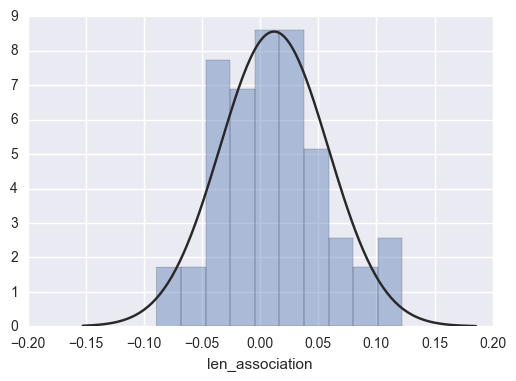

In [221]:
sns.distplot(length_binary.len_association, bins = 10, kde=False, fit=stats.norm)
plt.show()

In [225]:
df_method_list = [length_binary, testing_binary, trimmed_bigram]
comparison_df = functools.reduce(lambda left,right: pd.merge(left,right,on='dublet'), df_method_list)
del comparison_df['dublet']
#comparison_df.head(10)
comparison_df.columns = ['binary_length', 'binary', 'bigrams']
#comparison_df['binary'] = abs(comparison_df['binary'].values)
#comparison_df['bigrams'] = abs(comparison_df['bigrams'].values)
pearson_test = comparison_df.corr(method='pearson')
kendall_test = comparison_df.corr(method='kendall')
spearman_test = comparison_df.corr(method='spearman')
print('Pearson Test:')
print(pearson_test)

print('Kendall Test:')
print(kendall_test)

print('Spearman Test:')
print(spearman_test)

Pearson Test:
               binary_length    binary   bigrams
binary_length       1.000000  0.583093  0.535073
binary              0.583093  1.000000  0.898545
bigrams             0.535073  0.898545  1.000000
Kendall Test:
               binary_length    binary   bigrams
binary_length       1.000000  0.384512  0.404714
binary              0.384512  1.000000  0.608081
bigrams             0.404714  0.608081  1.000000
Spearman Test:
               binary_length    binary   bigrams
binary_length       1.000000  0.542569  0.557648
binary              0.542569  1.000000  0.766739
bigrams             0.557648  0.766739  1.000000


In [226]:
def get_top_len_association(bistats):
    t2_llr_params = stats.gamma.fit(bistats.len_association.values)
    t2_llr_vals = stats.gamma.ppf([1-0.05], t2_llr_params[0], loc=t2_llr_params[1], scale=t2_llr_params[2])
    top_hits = bistats[['dublet', 'len_association']].loc[((bistats['len_association'] > t2_llr_vals[0]) )]
    return top_hits

top_hits = get_top_len_association(length_binary)
top_hits

,dublet,len_association
40,"(6, 7)",0.122323
35,"(5, 7)",0.108242
45,"(7, 8)",0.103264
22,"(3, 7)",0.095748


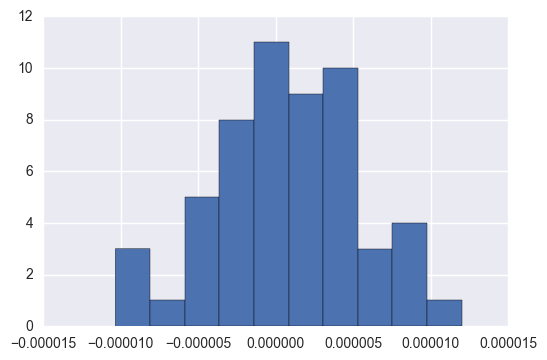

In [51]:
plt.hist(comparison_df.binary_length.values)
plt.show()

In [ ]:
condf = full_bigram_analysis(s3path)
condf.head()

In [ ]:
plt.hist(condf.w_pmi)
plt.show()

In [ ]:
def read_in(path):
    dfs1 = pd.read_csv(path, engine='python', sep=None, header=None)
    dfs1.columns = ['count','rawcode']
    dfs1 = dfs1.loc[dfs1['count'] > 2]
    return dfs1

In [ ]:
def extract_code(df):
    toparse = df['rawcode'].tolist()
    code = []
    for s in toparse:
        singlecode = [c for c in s if not c.isupper()]
        jcode = ''.join(singlecode)
        code.append(jcode)
    df['code'] = code
    df['code'] = df['code'].str.replace('r', ' ')
    df['code'] = df['code'].str.replace('f', ' ')
    return df

In [ ]:
def extract_weighted_bigram_list(weighted_list):
    weighted_bigram_list = []
    for t in weighted_list:
        c = list(itertools.combinations(t[0], 2))
        nn = list(itertools.repeat(t[1], len(c)))
        d = dict(zip(c, nn))
        weighted_bigram_list.append(d)
    return weighted_bigram_list

In [ ]:
def extract_weighted_mono_freq(weighted_bigram_list):
    mono_dict = defaultdict(list) 
    for d in weighted_bigram_list:
        for k, v in d.items():
            mono_dict[k[0]].append(v)
            mono_dict[k[1]].append(v)
    r = dict((k, sum(v)) for k, v in mono_dict.items())
    return r

In [ ]:
def extract_weighted_bifreq(weighted_bigram_list):
    w_bifreq = defaultdict(list)  
    for d in weighted_bigram_list:
        for k, v in d.items():
            w_bifreq[k].append(v)
    return w_bifreq

In [ ]:
def get_monofreq_from_commalist(comma_list):
    tuple_list = []
    for l in comma_list:
        c = list(itertools.combinations(l, 2))
        tuple_list.append(c)
    tmono = []
    for l in tuple_list:
        for e in l:
            tmono.append(list(e))
    monofreq = dict(Counter(itertools.chain(*tmono)))
    return monofreq
def get_bifreq_from_commalist(comma_list):
    tuple_list = []
    for l in comma_list:
        c = list(itertools.combinations(l, 2))
        tuple_list.append(c)
    bifreq = dict(Counter(itertools.chain(*tuple_list)))
    return bifreq


In [ ]:
def remove_permutations(dic):
    r = sum((Counter({frozenset(k): v}) for k, v in dic.items()), Counter())
    return r
def remove_weighted_permutations(dic):
    r = sum((Counter({frozenset(k): sum(v)}) for k, v in dic.items()), Counter())
    return r

In [ ]:
def calc_llr(w12, w1, w2, n):
    return bigram_measures.likelihood_ratio(w12, (w1, w2), n)

In [ ]:
def calculate_bigram_statistics(comma_list, weighted_bigram_list):
    bifreq = get_bifreq_from_commalist(comma_list)
    monofreq = get_monofreq_from_commalist(comma_list)
    ###Setup Base Dataframe###
    bistats = pd.DataFrame(list(remove_permutations(bifreq).items()), columns=['bigram', 'bigram_freq'])
    w_bistats = pd.DataFrame(list(remove_weighted_permutations(extract_weighted_bifreq(weighted_bigram_list)).items()),
                             columns=['bigram', 'w_bigram_freq'])
    bistats = pd.merge(bistats, w_bistats, on='bigram', how='inner')
    bistats['bigram']= [list(x) for x in bistats.bigram]
    for e in bistats['bigram']:
        if len(e) == 1:
            e.append(e[0])
    bistats['unigram_one'] = [e[0] for e in bistats['bigram']]
    bistats['unigram_two'] = [e[1] for e in bistats['bigram']]

    ###Calc Monograms###
    monostats = pd.DataFrame(list(monofreq.items()), columns=['unigram_one', 'monogram_freq'])
    monostats2 = pd.DataFrame(list(monofreq.items()), columns=['unigram_two', 'monogram_freq'])
    bistats2 = pd.merge(bistats, monostats, left_on='unigram_one', right_on='unigram_one', how='inner')
    bistats3 = pd.merge(bistats2, monostats, left_on='unigram_two', right_on='unigram_one', how='right')
    del bistats3['unigram_one_y']

    ###Calc weighted monograms###
    w_monostats = pd.DataFrame(list(extract_weighted_mono_freq(weighted_bigram_list).items()), 
                               columns=['unigram', 'w_monogram_freq'])
    bistats3 = pd.merge(bistats3, w_monostats, left_on='unigram_one_x', right_on='unigram', how='inner')
    bistats3 = pd.merge(bistats3, w_monostats, left_on='unigram_two', right_on='unigram', how='inner')
    del bistats3['unigram_x']
    del bistats3['unigram_y']
    bistats3['w_nfiller'] = w_monostats['w_monogram_freq'].sum()

    ###Calculations for unweighted bigrams###
    #biprop = bistats3.bigram_freq/float(sum(bifreq.values()))
    #unioneprop = bistats3.monogram_freq_x/float(sum(monofreq.values()))
    #unitwoprop = bistats3.monogram_freq_y/float(sum(monofreq.values()))
    bistats3['n_filler'] = sum(monofreq.values())
    #bistats3['pmi'] = np.log2(biprop/(unioneprop*unitwoprop))
    #substats = bistats3[['bigram_freq','monogram_freq_x','monogram_freq_y','n_filler']]
    #for_llr_tuples = [tuple(x) for x in substats.values]
    #bistats3['llr'] = [calc_llr(t[0], t[1], t[2], t[3]) for t in for_llr_tuples]
    #bistats3['dice'] = 2*bistats3.bigram_freq/(bistats3.monogram_freq_x + bistats3.monogram_freq_y)
    #bistats3['chi'] = [bigram_measures.chi_sq(t[0],(t[1],t[2]),t[3]) for t in for_llr_tuples]

    ###Calculations for weighted bigrams###
    #w_biprop = bistats3.w_bigram_freq/float(sum(remove_weighted_permutations(extract_weighted_bifreq(weighted_bigram_list)).values()))
    #w_unioneprop = bistats3.w_monogram_freq_x/float(sum(extract_weighted_mono_freq(weighted_bigram_list).values()))
    #w_unitwoprop = bistats3.w_monogram_freq_y/float(sum(extract_weighted_mono_freq(weighted_bigram_list).values()))
    #bistats3['w_pmi'] = np.log2(w_biprop/(w_unioneprop*w_unitwoprop))
    #w_substats = bistats3[['w_bigram_freq','w_monogram_freq_x','w_monogram_freq_y','w_nfiller']]
    #w_for_llr_tuples = [tuple(x) for x in w_substats.values]
    #bistats3['w_llr'] = [calc_llr(t[0], t[1], t[2], t[3]) for t in w_for_llr_tuples]
    #bistats3['w_dice'] = 2*bistats3.w_bigram_freq/(bistats3.w_monogram_freq_x + bistats3.w_monogram_freq_y)
    #bistats3['w_chi'] = [bigram_measures.chi_sq(t[0],(t[1],t[2]),t[3]) for t in w_for_llr_tuples]
    return bistats3

In [ ]:
def get_top_hits(bistats):
    llr_params = stats.gamma.fit(bistats.llr.values)
    llr_vals = stats.gamma.ppf([1-0.025], llr_params[0], loc=llr_params[1], scale=llr_params[2])
    pmi_params = stats.cauchy.fit(bistats.pmi.values)
    pmi_vals = stats.cauchy.ppf([1-0.05], pmi_params[0], scale=pmi_params[1])
    top_hits = bistats[['bigram','pmi','llr','dice']].loc[(bistats['pmi'] > pmi_vals[0])
                        | (bistats['llr'] > llr_vals[0])
                        | (bistats['dice'] > dice_vals[0])]
    return top_hits

In [ ]:
def get_w_top_posit_hits(bistats):
    w_llr_params = stats.gamma.fit(bistats.w_llr.values)
    w_llr_vals = stats.gamma.ppf([1-0.025], w_llr_params[0], loc=w_llr_params[1], scale=w_llr_params[2])
    w_pmi_params = stats.cauchy.fit(bistats.w_pmi.values)
    w_pmi_vals = stats.cauchy.ppf([1-0.05], w_pmi_params[0], scale=w_pmi_params[1])
    w_top_hits = bistats[['bigram','w_pmi','w_llr','w_dice']].loc[(bistats['w_pmi'] > w_pmi_vals[0])
                        | (bistats['w_llr'] > w_llr_vals[0])
                        | (bistats['w_dice'] > w_dice_vals[0])]
    return w_top_hits

In [ ]:
def alt_llr(obs, expect):
    return (obs* np.log2(obs/expect))

In [ ]:
def chi_contin(obs, expect):
    return ((obs - expect)**2)/expect

In [ ]:
def bi_llr(c1, c2, c12, n):
    # H0: Independence p(w1,w2) = p(w1,~w2) = c2/N
    p0 = c2 / n
    # H1: Dependence, p(w1,w2) = c12/N
    p10 = c12 / n
    # H1: p(~w1,w2) = (c2-c12)/N
    p11 = (c2 - c12) / n
    # binomial probabilities
    # H0: b(c12; c1, p0),  b(c2-c12; N-c1, p0)
    # H1: b(c12, c1, p10), b(c2-c12; N-c1, p11)
    probs = np.matrix([[binom(c1, p0).logpmf(c12), binom(n - c1, p0).logpmf(c2 - c12)],
                       [binom(c1, p10).logpmf(c12), binom(n - c1, p11).logpmf(c2 - c12)]])
    # LLR = p(H1) / p(H0)
    return np.sum(probs[1, :]) - np.sum(probs[0, :])
binom_llr = np.vectorize(bi_llr)

In [ ]:
def generate_weighted_contingencystats(t2_df):
    ###Expected Values generated from Monogram Frequencies###
    t2_df['w_eab'] = np.where(t2_df['unigram_one_x'] != t2_df['unigram_two'],
                            ((t2_df.w_monogram_freq_x/t2_df.w_nfiller)*(t2_df.w_monogram_freq_y/t2_df.w_nfiller)*2*t2_df.w_bigram_freq.sum()),
                            ((t2_df.w_monogram_freq_x/t2_df.w_nfiller)*(t2_df.w_monogram_freq_y/t2_df.w_nfiller)*t2_df.w_bigram_freq.sum()))
    t2_df['w_eanotb'] = ((((t2_df.w_monogram_freq_x/t2_df.w_nfiller))*(1-(t2_df.w_monogram_freq_y/t2_df.w_nfiller)))*2*t2_df.w_bigram_freq.sum())
    t2_df['w_enotab'] = ((1-(t2_df.w_monogram_freq_x/t2_df.w_nfiller))*((t2_df.w_monogram_freq_y/t2_df.w_nfiller)))*2*t2_df.w_bigram_freq.sum()
    t2_df['w_enotanotb'] = t2_df.w_bigram_freq.sum() - t2_df.w_eab - t2_df.w_eanotb - t2_df.w_enotab                

    ###Observed Values###
    ###Find Observed AB###
    t2_df['w_oab'] = t2_df.w_bigram_freq

    ###Calculate Corrections for Observed ~AB or A~B when A==B###
    doublematch = t2_df[['unigram_one_x', 'unigram_two','w_bigram_freq']].loc[t2_df['unigram_one_x'] == t2_df['unigram_two']]
    wa = doublematch[['unigram_one_x','w_bigram_freq']]
    wb = doublematch[['unigram_two','w_bigram_freq']]
    wa.rename(columns={'w_bigram_freq': 'w_a_correction'}, inplace=True)
    wb.rename(columns={'w_bigram_freq': 'w_b_correction'}, inplace=True)
    t2_df = pd.merge(t2_df, wa, on='unigram_one_x', how='left')
    t2_df = pd.merge(t2_df, wb, on='unigram_two', how='left')
    t2_df.loc[t2_df['unigram_one_x'] == t2_df['unigram_two'], 'w_a_correction'] = 0
    t2_df.loc[t2_df['unigram_one_x'] == t2_df['unigram_two'], 'w_b_correction'] = 0

    ###Find Observed A~B###
    w_notabvars = t2_df[['unigram_two','unigram_one_x']].values
    w_onotab_matches = (w_notabvars[:, None] == w_notabvars[:, [0]]).any(-1)
    t2_df['w_onotab'] = (t2_df['w_bigram_freq'].values @ w_onotab_matches ) - t2_df['w_bigram_freq'] + t2_df['w_b_correction']

    ###Find Observed ~AB###
    w_anotbvars = t2_df[['unigram_one_x', 'unigram_two']].values
    w_oanotb_matches = (w_anotbvars[:, None] == w_anotbvars[:, [0]]).any(-1)
    t2_df['w_oanotb'] = (t2_df['w_bigram_freq'].values @ w_oanotb_matches ) - t2_df['w_bigram_freq'] + t2_df['w_a_correction']


    ###Find Observed ~A~B###
    #t2_df['onotanotb'] = t2_df['bigram_freq'].sum() - t2_df.groupby('unigram_one_x')['bigram_freq'].transform('sum') - t2_df.groupby('unigram_two')['bigram_freq'].transform('sum')
    t2_df['w_onotanotb'] = t2_df['w_bigram_freq'].sum() - (t2_df['w_bigram_freq'].values @ w_oanotb_matches ) - (t2_df['w_bigram_freq'].values @ w_onotab_matches )

    ###Calculate Statistics for Expected vs Observed Contingency Tables###
    #t2_df['asum'] = t2_df['bigram_freq'].sum() #To Check Contingency Table Calculations
    t2_df['w_llr'] = 2*((alt_llr(t2_df.w_oab, t2_df.w_eab) + alt_llr(t2_df.w_oanotb, t2_df.w_eanotb) + alt_llr(t2_df.w_onotab, t2_df.w_enotab) + alt_llr(t2_df.w_onotanotb, t2_df.w_enotanotb)))
    t2_df['w_chi2'] = (chi_contin(t2_df.w_oab, t2_df.w_eab) + chi_contin(t2_df.w_oanotb, t2_df.w_eanotb) + chi_contin(t2_df.w_onotab, t2_df.w_enotab) + chi_contin(t2_df.w_onotanotb, t2_df.w_enotanotb))
    t2_df['w_pmi'] = np.log2(t2_df.w_oab/t2_df.w_eab)
    
    #t2_df['w_llr'] = binom_llr(t2_df.monogram_freq_x, t2_df.monogram_freq_y, t2_df.w_oab, t2_df.w_nfiller)
    
    return t2_df

In [ ]:
def generate_unweighted_contingencystats(t2_df):
    ###Expected Values generated from Monogram Frequencies###
    t2_df['eab'] = np.where(t2_df['unigram_one_x'] != t2_df['unigram_two'],
                            ((t2_df.monogram_freq_x/t2_df.n_filler)*(t2_df.monogram_freq_y/t2_df.n_filler)*2*t2_df.bigram_freq.sum()),
                            ((t2_df.monogram_freq_x/t2_df.n_filler)*(t2_df.monogram_freq_y/t2_df.n_filler)*t2_df.bigram_freq.sum()))
    t2_df['eanotb'] = ((((t2_df.monogram_freq_x/t2_df.n_filler))*(1-(t2_df.monogram_freq_y/t2_df.n_filler)))*2*t2_df.bigram_freq.sum())
    t2_df['enotab'] = ((1-(t2_df.monogram_freq_x/t2_df.n_filler))*((t2_df.monogram_freq_y/t2_df.n_filler)))*2*t2_df.bigram_freq.sum()
    t2_df['enotanotb'] = t2_df.bigram_freq.sum() - t2_df.eab - t2_df.eanotb - t2_df.enotab                

    ###Observed Values###
    ###Find Observed AB###
    t2_df['oab'] = t2_df.bigram_freq

    ###Calculate Corrections for Observed ~AB or A~B when A==B###
    doublematch = t2_df[['unigram_one_x', 'unigram_two','bigram_freq']].loc[t2_df['unigram_one_x'] == t2_df['unigram_two']]
    a = doublematch[['unigram_one_x','bigram_freq']]
    b = doublematch[['unigram_two','bigram_freq']]
    a.rename(columns={'bigram_freq': 'a_correction'}, inplace=True)
    b.rename(columns={'bigram_freq': 'b_correction'}, inplace=True)
    t2_df = pd.merge(t2_df, a, on='unigram_one_x', how='left')
    t2_df = pd.merge(t2_df, b, on='unigram_two', how='left')
    t2_df.loc[t2_df['unigram_one_x'] == t2_df['unigram_two'], 'a_correction'] = 0
    t2_df.loc[t2_df['unigram_one_x'] == t2_df['unigram_two'], 'b_correction'] = 0

    ###Find Observed A~B###
    notabvars = t2_df[['unigram_two','unigram_one_x']].values
    onotab_matches = (notabvars[:, None] == notabvars[:, [0]]).any(-1)
    t2_df['onotab'] = (t2_df['bigram_freq'].values @ onotab_matches ) - t2_df['bigram_freq'] + t2_df['b_correction']

    ###Find Observed ~AB###
    anotbvars = t2_df[['unigram_one_x', 'unigram_two']].values
    oanotb_matches = (anotbvars[:, None] == anotbvars[:, [0]]).any(-1)
    t2_df['oanotb'] = (t2_df['bigram_freq'].values @ oanotb_matches ) - t2_df['bigram_freq'] + t2_df['a_correction']


    ###Find Observed ~A~B###
    #t2_df['onotanotb'] = t2_df['bigram_freq'].sum() - t2_df.groupby('unigram_one_x')['bigram_freq'].transform('sum') - t2_df.groupby('unigram_two')['bigram_freq'].transform('sum')
    t2_df['onotanotb'] = t2_df['bigram_freq'].sum() - (t2_df['bigram_freq'].values @ oanotb_matches ) - (t2_df['bigram_freq'].values @ onotab_matches )

    ###Calculate Statistics for Expected vs Observed Contingency Tables###
    t2_df['asum'] = t2_df['bigram_freq'].sum() #To Check Contingency Table Calculations
    t2_df['llr'] = 2*((alt_llr(t2_df.oab, t2_df.eab) + alt_llr(t2_df.oanotb, t2_df.eanotb) + alt_llr(t2_df.onotab, t2_df.enotab) + alt_llr(t2_df.onotanotb, t2_df.enotanotb)))
    t2_df['chi2'] = (chi_contin(t2_df.oab, t2_df.eab) + chi_contin(t2_df.oanotb, t2_df.eanotb) + chi_contin(t2_df.onotab, t2_df.enotab) + chi_contin(t2_df.onotanotb, t2_df.enotanotb))
    t2_df['pmi'] = np.log2(t2_df.oab/t2_df.eab)
    
    return t2_df

In [ ]:
def full_bigram_analysis(path):
    df = extract_code(read_in(path))
    dfs = df[['count','code']]
    #if dfs['count'] > dfs['count'].mean():
    #    dfs['mcount'] = dfs['count'] - ((dfs['count']-dfs['count'].mean())*0.8)
    #if dfs['count'] < dfs['count'].mean():
    #    dfs['mcount'] = dfs['count'] + ((dfs['count'].mean() - dfs['count'])*0.8)
    #dfs['mcount'] = np.where(dfs['count'] >= dfs['count'].mean(), (dfs['count'] - ((dfs['count']-dfs['count'].mean())*0.8))/dfs['count'].mean(),
    #                         (dfs['count'] + ((dfs['count'].mean() - dfs['count'])*0.8))/dfs['count'].mean())
    #dfs['mcount'] = dfs['count']/dfs['count'].mean()
    #dfs['mcount'] = dfs['count']/dfs['count'].max()
    dfs['mcount'] = dfs['count']

    split_list = []
    for l in dfs['code'].values:
        split_list.append(l.split())
    
    comma_list = []
    for l in split_list:
        results = list(map(int, l))
        comma_list.append(results)
    
    dfs['code'] = comma_list
    
    weighted_list = list((zip(dfs['code'].values, dfs['mcount'].values)))
    weighted_bigram_list = extract_weighted_bigram_list(weighted_list)
    bifreq = get_bifreq_from_commalist(comma_list)
    monofreq = get_monofreq_from_commalist(comma_list)
    bistats = calculate_bigram_statistics(comma_list, weighted_bigram_list)
    bistats = generate_unweighted_contingencystats(bistats)
    bistats = generate_weighted_contingencystats(bistats)
    return bistats

In [ ]:
def get_w_low_hits(bistats):
    w_llr_params = stats.gamma.fit(bistats.w_llr_diff.values)
    w_llr_vals = stats.gamma.ppf([1-0.05], w_llr_params[0], loc=w_llr_params[1], scale=w_llr_params[2])
    w_pmi_params = stats.gamma.fit(bistats.w_pmi_diff.values)
    w_pmi_vals = stats.gamma.ppf([1-0.025], w_pmi_params[0], loc=w_pmi_params[1], scale=w_pmi_params[2])
    w_top_hits = bistats[['bigram','w_llr_t2', 'w_llr_t4','w_llr_t6','w_llr_t7','w_pmi_t2', 'w_pmi_t4','w_pmi_t6','w_pmi_t7',
                          'w_dice_t2', 'w_dice_t4','w_dice_t6','w_dice_t7','w_pmi_diff','w_llr_diff','w_dice_diff']].loc[(bistats['w_pmi_diff'] > w_pmi_vals[0])
                        | (bistats['w_llr_diff'] > w_llr_vals[0])
                        | (bistats['w_dice_diff'] > w_dice_vals[0])]
    return w_top_hits

In [ ]:
def get_w_low_timed_hits(bistats):
    t2_llr_params = stats.gamma.fit(bistats.w_llr_t2.values)
    t2_llr_vals = stats.gamma.ppf([1-0.7], t2_llr_params[0], loc=t2_llr_params[1], scale=t2_llr_params[2])
    t4_llr_params = stats.gamma.fit(bistats.w_llr_t4.values)
    t4_llr_vals = stats.gamma.ppf([1-0.7], t4_llr_params[0], loc=t4_llr_params[1], scale=t4_llr_params[2])
    t6_llr_params = stats.gamma.fit(bistats.w_llr_t6.values)
    t6_llr_vals = stats.gamma.ppf([1-0.7], t6_llr_params[0], loc=t6_llr_params[1], scale=t6_llr_params[2])
    t7_llr_params = stats.gamma.fit(bistats.w_llr_t7.values)
    t7_llr_vals = stats.gamma.ppf([1-0.7], t7_llr_params[0], loc=t7_llr_params[1], scale=t7_llr_params[2])
    w_top_hits = bistats[['bigram','w_llr_t2', 'w_llr_t4','w_llr_t6','w_llr_t7']].loc[((bistats['w_llr_t2'] < t2_llr_vals[0]) )
                                                                                                  & ((bistats['w_llr_t4'] < t4_llr_vals[0]) )
                                                                                                    &((bistats['w_llr_t6'] < t6_llr_vals[0]) )
                                                                                                      &((bistats['w_llr_t7'] < t7_llr_vals[0]))]
    return w_top_hits

In [ ]:
def get_w_high_timed_hits(bistats):
    t2_llr_params = stats.gamma.fit(bistats.w_llr_t2.values)
    t2_llr_vals = stats.gamma.ppf([1-0.1], t2_llr_params[0], loc=t2_llr_params[1], scale=t2_llr_params[2])
    t4_llr_params = stats.gamma.fit(bistats.w_llr_t4.values)
    t4_llr_vals = stats.gamma.ppf([1-0.1], t4_llr_params[0], loc=t4_llr_params[1], scale=t4_llr_params[2])
    t6_llr_params = stats.gamma.fit(bistats.w_llr_t6.values)
    t6_llr_vals = stats.gamma.ppf([1-0.1], t6_llr_params[0], loc=t6_llr_params[1], scale=t6_llr_params[2])
    t7_llr_params = stats.gamma.fit(bistats.w_llr_t7.values)
    t7_llr_vals = stats.gamma.ppf([1-0.1], t7_llr_params[0], loc=t7_llr_params[1], scale=t7_llr_params[2])
    llr_top_hits = bistats[['bigram','w_llr_t2', 'w_llr_t4','w_llr_t6','w_llr_t7','w_pmi_t2', 'w_pmi_t4','w_pmi_t6','w_pmi_t7']].loc[((bistats['w_llr_t2'] > t2_llr_vals[0]) )
                                                                                                  | ((bistats['w_llr_t4'] > t4_llr_vals[0]) )
                                                                                                    |((bistats['w_llr_t6'] > t6_llr_vals[0]) )
                                                                                                      |((bistats['w_llr_t7'] > t7_llr_vals[0]))]
    #f_top_hits = llr_top_hits.loc[(llr_top_hits['w_pmi_t2'] > 0) & (llr_top_hits['w_pmi_t4'] > 0) &
    #                              (llr_top_hits['w_pmi_t6'] > 0) & (llr_top_hits['w_pmi_t7'] > 0)]
    return llr_top_hits

In [ ]:
def get_w_high_pmi_timed_hits(bistats):
    t2_llr_params = stats.gamma.fit(bistats.w_pmi_24.values)
    t2_llr_vals = stats.gamma.ppf([1-0.05], t2_llr_params[0], loc=t2_llr_params[1], scale=t2_llr_params[2])
    t4_llr_params = stats.gamma.fit(bistats.w_pmi_48.values)
    t4_llr_vals = stats.gamma.ppf([1-0.05], t4_llr_params[0], loc=t4_llr_params[1], scale=t4_llr_params[2])
    t6_llr_params = stats.gamma.fit(bistats.w_pmi_72.values)
    t6_llr_vals = stats.gamma.ppf([1-0.05], t6_llr_params[0], loc=t6_llr_params[1], scale=t6_llr_params[2])
    t7_llr_params = stats.gamma.fit(bistats.w_pmi_96.values)
    t7_llr_vals = stats.gamma.ppf([1-0.05], t7_llr_params[0], loc=t7_llr_params[1], scale=t7_llr_params[2])
    llr_top_hits = bistats[['bigram','w_pmi_24', 'w_pmi_48','w_pmi_72','w_pmi_96']].loc[((bistats['w_pmi_24'] > t2_llr_vals[0]) )
                                                                                                  | ((bistats['w_pmi_48'] > t4_llr_vals[0]) )
                                                                                                    |((bistats['w_pmi_72'] > t6_llr_vals[0]) )
                                                                                                      |((bistats['w_pmi_96'] > t7_llr_vals[0]))]
    return llr_top_hits

In [ ]:
def get_w_low_pmi_timed_hits(bistats):
    t2_llr_params = stats.gamma.fit(bistats.w_pmi_24.values)
    t2_llr_vals = stats.gamma.ppf([0.05], t2_llr_params[0], loc=t2_llr_params[1], scale=t2_llr_params[2])
    t4_llr_params = stats.gamma.fit(bistats.w_pmi_48.values)
    t4_llr_vals = stats.gamma.ppf([0.05], t4_llr_params[0], loc=t4_llr_params[1], scale=t4_llr_params[2])
    t6_llr_params = stats.gamma.fit(bistats.w_pmi_72.values)
    t6_llr_vals = stats.gamma.ppf([0.05], t6_llr_params[0], loc=t6_llr_params[1], scale=t6_llr_params[2])
    t7_llr_params = stats.gamma.fit(bistats.w_pmi_96.values)
    t7_llr_vals = stats.gamma.ppf([0.05], t7_llr_params[0], loc=t7_llr_params[1], scale=t7_llr_params[2])
    llr_top_hits = bistats[['bigram','w_pmi_24', 'w_pmi_48','w_pmi_72','w_pmi_96']].loc[((bistats['w_pmi_24'] < t2_llr_vals[0]) )
                                                                                                  | ((bistats['w_pmi_48'] < t4_llr_vals[0]) )
                                                                                                    |((bistats['w_pmi_72'] < t6_llr_vals[0]) )
                                                                                                      |((bistats['w_pmi_96'] < t7_llr_vals[0]))]
    return llr_top_hits

In [ ]:
def get_w_low_lowex_pmi_timed_hits(bistats):
    t2_llr_params = stats.gamma.fit(bistats.w_pmi_24.values)
    t2_llr_vals = stats.gamma.ppf([0.05], t2_llr_params[0], loc=t2_llr_params[1], scale=t2_llr_params[2])
    t4_llr_params = stats.gamma.fit(bistats.w_pmi_48.values)
    t4_llr_vals = stats.gamma.ppf([0.05], t4_llr_params[0], loc=t4_llr_params[1], scale=t4_llr_params[2])
    t6_llr_params = stats.gamma.fit(bistats.w_pmi_72.values)
    t6_llr_vals = stats.gamma.ppf([0.05], t6_llr_params[0], loc=t6_llr_params[1], scale=t6_llr_params[2])
    llr_top_hits = bistats[['bigram','w_pmi_24', 'w_pmi_48','w_pmi_72']].loc[((bistats['w_pmi_24'] < t2_llr_vals[0]) )
                                                                                                  | ((bistats['w_pmi_48'] < t4_llr_vals[0]) )
                                                                                                    |((bistats['w_pmi_72'] < t6_llr_vals[0]) )
                                                                                                      ]
    return llr_top_hits

In [ ]:
def get_w_high_lowex_pmi_timed_hits(bistats):
    t2_llr_params = stats.gamma.fit(bistats.w_pmi_24.values)
    t2_llr_vals = stats.gamma.ppf([1 - 0.05], t2_llr_params[0], loc=t2_llr_params[1], scale=t2_llr_params[2])
    t4_llr_params = stats.gamma.fit(bistats.w_pmi_48.values)
    t4_llr_vals = stats.gamma.ppf([1 - 0.05], t4_llr_params[0], loc=t4_llr_params[1], scale=t4_llr_params[2])
    t6_llr_params = stats.gamma.fit(bistats.w_pmi_72.values)
    t6_llr_vals = stats.gamma.ppf([1 - 0.05], t6_llr_params[0], loc=t6_llr_params[1], scale=t6_llr_params[2])
    llr_top_hits = bistats[['bigram','w_pmi_24', 'w_pmi_48','w_pmi_72']].loc[((bistats['w_pmi_24'] > t2_llr_vals[0]) )
                                                                                                  | ((bistats['w_pmi_48'] > t4_llr_vals[0]) )
                                                                                                    |((bistats['w_pmi_72'] > t6_llr_vals[0]) )
                                                                                                      ]
    return llr_top_hits

In [ ]:
def get_unw_timed_hits(bistats):
    dice_params = stats.gamma.fit(bistats.dice_diff.values)
    dice_vals = stats.gamma.ppf([1-0.05], dice_params[0], loc=dice_params[1], scale=dice_params[2])
    llr_params = stats.chi2.fit(bistats.w_llr_diff.values)
    llr_vals = stats.chi2.ppf([1-0.05], llr_params[0], loc=llr_params[1], scale=llr_params[2])
    pmi_params = stats.gamma.fit(bistats.pmi_diff.values)
    pmi_vals = stats.gamma.ppf([1-0.025], pmi_params[0], loc=pmi_params[1], scale=pmi_params[2])
    top_hits = bistats[['bigram','llr_t2', 'llr_t4','llr_t6','llr_t7','pmi_t2', 'pmi_t4','pmi_t6','pmi_t7',
                          'dice_t2', 'dice_t4','dice_t6','dice_t7','pmi_diff','llr_diff','dice_diff']].loc[(bistats['pmi_diff'] > pmi_vals[0])
                        | (bistats['llr_diff'] > llr_vals[0])
                        | (bistats['dice_diff'] > dice_vals[0])]
    return top_hits

In [ ]:
def get_unw_llr_str_timed_hits(bistats):
    t2_llr_params = stats.chi2.fit(bistats.llr_t2.values)
    t2_llr_vals = stats.chi2.ppf([1-0.05], t2_llr_params[0], loc=t2_llr_params[1], scale=t2_llr_params[2])
    t4_llr_params = stats.chi2.fit(bistats.llr_t4.values)
    t4_llr_vals = stats.chi2.ppf([1-0.05], t4_llr_params[0], loc=t4_llr_params[1], scale=t4_llr_params[2])
    t6_llr_params = stats.chi2.fit(bistats.llr_t6.values)
    t6_llr_vals = stats.chi2.ppf([1-0.05], t6_llr_params[0], loc=t6_llr_params[1], scale=t6_llr_params[2])
    t7_llr_params = stats.chi2.fit(bistats.llr_t7.values)
    t7_llr_vals = stats.chi2.ppf([1-0.05], t7_llr_params[0], loc=t7_llr_params[1], scale=t7_llr_params[2])
    w_top_hits = bistats[['bigram','llr_t2', 'llr_t4','llr_t6','llr_t7','llr_diff']].loc[(bistats['llr_t2'] > t2_llr_vals[0])
                                                                                                  | (bistats['llr_t4'] > t4_llr_vals[0])
                                                                                                    |(bistats['llr_t6'] > t6_llr_vals[0])
                                                                                                      |(bistats['llr_t7'] > t7_llr_vals[0])]
    return w_top_hits

In [ ]:
#low expression populations
s1path ="C:\\Users\\Wolf\\Desktop\\Syn Pro\\Complete data\\S1.fa.uniq.tcga.reform.all.csv"
s3path ="C:\\Users\\Wolf\\Desktop\\Syn Pro\\Complete data\\S3.fa.uniq.tcga.reform.all.csv"
s5path ="C:\\Users\\Wolf\\Desktop\\Syn Pro\\Complete data\\S5.fa.uniq.tcga.reform.all.csv"
#high expression populations
s2path ="C:\\Users\\Wolf\\Desktop\\Syn Pro\\Complete data\\S2.fa.uniq.tcga.reform.all.csv"
s4path ="C:\\Users\\Wolf\\Desktop\\Syn Pro\\Complete data\\S4.fa.uniq.tcga.reform.all.csv"
s6path ="C:\\Users\\Wolf\\Desktop\\Syn Pro\\Complete data\\S6.fa.uniq.tcga.reform.all.csv"
s7path ="C:\\Users\\Wolf\\Desktop\\Syn Pro\\Complete data\\S7.fa.uniq.tcga.reform.all.csv"

In [ ]:
#low expression
t1_df = full_bigram_analysis(s1path)
t3_df = full_bigram_analysis(s3path)
t5_df = full_bigram_analysis(s5path)
#high expression
t2_df = full_bigram_analysis(s2path)
t4_df = full_bigram_analysis(s4path)
t6_df = full_bigram_analysis(s6path)
t7_df = full_bigram_analysis(s7path)

In [ ]:
sns.distplot(t2_df.w_chi2, kde=False, fit=stats.gamma)
plt.xlabel('Weighted chi2 Score')
plt.ylabel('Relative Density')
plt.title('Histogram of Chi Squared Value of Contingency Tables for each Bigram')
plt.show()

In [ ]:
sns.distplot(t2_df.w_llr.values, kde=False, fit=stats.cauchy)
plt.xlabel('Weighted Log Likelihood Ratio (LLR)')
plt.ylabel('Relative Density')
plt.title('Histogram of LLR of Contingency Tables for each Bigram')
plt.xticks(rotation=60)
plt.show()

In [ ]:
sns.distplot(t3_df.w_pmi, kde=False, rug=False)
#pmi_params = stats.gengamma.fit(t3_df.w_pmi_48)
#rv = stats.gamma(pmi_params[0],pmi_params[1],pmi_params[2])
#x = np.linspace(-1,1) 
#h = plt.plot(x, rv.pdf(x))
plt.xlabel('Weighted Pointwise Mutual Information (PMI)')
plt.ylabel('Frequency')
plt.title('Histogram of Bigram Weighted PMI')
plt.xticks(rotation=60)
plt.show()

In [ ]:
###This is just diagnostic code for exploration###
tt2_llr_params = stats.gamma.fit(t2_df.w_llr.values)
tt2_llr_vals = stats.gamma.ppf([0.9], tt2_llr_params[0], loc=tt2_llr_params[1], scale=tt2_llr_params[2])
passchi_df = t2_df.loc[t2_df.w_llr > tt2_llr_vals[0]]
print(tt2_llr_vals)
print(passchi_df.shape)
t2_df.head()

In [ ]:
t2_df['bigram'] = t2_df['bigram'].apply(frozenset)
t4_df['bigram'] = t4_df['bigram'].apply(frozenset)
t6_df['bigram'] = t6_df['bigram'].apply(frozenset)
t7_df['bigram'] = t7_df['bigram'].apply(frozenset)

In [ ]:
#suffix_list = ['_t2','_t4','_t6','_t7']

t2_df = t2_df.add_suffix('_24')
t4_df = t4_df.add_suffix('_48')
t6_df = t6_df.add_suffix('_72')
t7_df = t7_df.add_suffix('_96')
torename_list = ['bigram_24','bigram_48','bigram_72','bigram_96']
t_dfs = [t2_df, t4_df, t6_df, t7_df]
for i, df in enumerate(t_dfs):
    #df = df.add_suffix(suffix_list[i])
    df.rename(columns={torename_list[i]: 'bigram'}, inplace=True)
merge = functools.partial(pd.merge, on='bigram')
tmerged = functools.reduce(merge, t_dfs)

In [ ]:
trenamedict = {1:'E2F1', 2:'EGR1', 3:'FOS', 4:'HIF1A', 5:'JUN', 6:'NFAT', 7:'LEF1', 8:'NFkB', 9:'SP1', 10:'PU1', 11:'STAT4'}
tmerged['bigram'] = [list(x) for x in tmerged['bigram']]
def replace_matched_items(word_list, dictionary):
    new_list = [','.join([dictionary.get(item, item) for item in lst]) for lst in word_list]
    return new_list
tmerged['bigram'] = replace_matched_items(tmerged.bigram, trenamedict)

In [ ]:
#low expression
t1_df = full_bigram_analysis(s1path)
t3_df = full_bigram_analysis(s3path)
t5_df = full_bigram_analysis(s5path)

In [ ]:
t1_df['bigram'] = t1_df['bigram'].apply(frozenset)
t3_df['bigram'] = t3_df['bigram'].apply(frozenset)
t5_df['bigram'] = t5_df['bigram'].apply(frozenset)

In [ ]:
t1_df = t1_df.add_suffix('_24')
t3_df = t3_df.add_suffix('_48')
t5_df = t5_df.add_suffix('_72')
ltorename_list = ['bigram_24','bigram_48','bigram_72']
lt_dfs = [t1_df, t3_df, t5_df]
for i, df in enumerate(lt_dfs):
    #df = df.add_suffix(suffix_list[i])
    df.rename(columns={ltorename_list[i]: 'bigram'}, inplace=True)
flt_dfs = [t1_df, t3_df, t5_df]
ltmerged = functools.reduce(merge, lt_dfs)

In [ ]:
trenamedict = {1:'E2F1', 2:'EGR1', 3:'FOS', 4:'HIF1A', 5:'JUN', 6:'NFAT', 7:'LEF1', 8:'NFkB', 9:'SP1', 10:'PU1', 11:'STAT4'}
ltmerged['bigram'] = [list(x) for x in ltmerged['bigram']]
def replace_matched_items(word_list, dictionary):
    new_list = [','.join([dictionary.get(item, item) for item in lst]) for lst in word_list]
    return new_list
ltmerged['bigram'] = replace_matched_items(ltmerged.bigram, trenamedict)

In [ ]:
high_pmi_lowex = get_w_high_lowex_pmi_timed_hits(ltmerged)
low_pmi_lowex = get_w_low_lowex_pmi_timed_hits(ltmerged)
low_pmi_hits = get_w_low_pmi_timed_hits(tmerged)
top_pmi_hits = get_w_high_pmi_timed_hits(tmerged)

In [ ]:
def to_plot_pmi(t_plot_df):
    pmilist = list(t_plot_df.columns.values[1:len(t_plot_df.columns.values)])
    pmi_plot_df = pd.melt(t_plot_df, id_vars = ['bigram'], value_vars = pmilist)
    pmi_plot_df['measure'] = 'pmi'
    pmi_plot_df['time'] = pmi_plot_df['variable'].map(lambda x: str(x)[-2:])
    return pmi_plot_df

In [ ]:
#low hits from high expressors
lowpmiplot_df = to_plot_pmi(low_pmi_hits)
sns.set_palette(sns.color_palette("cubehelix", 16))
g = sns.factorplot(data=lowpmiplot_df, x='time', y='value', hue='bigram', col="bigram", col_wrap=4) 

In [ ]:
#top hits from high expressors
pmiplot_df = to_plot_pmi(top_pmi_hits)
sns.set_palette(sns.color_palette("cubehelix", 12))
g = sns.factorplot(data=pmiplot_df, x='time', y='value', hue='bigram', col="bigram", col_wrap=3) 

In [ ]:
#top hits from low expressors
tophit_lowex_plot = to_plot_pmi(high_pmi_lowex)
sns.set_palette(sns.color_palette("cubehelix", 16))
g = sns.factorplot(data=tophit_lowex_plot, x='time', y='value', hue='bigram', col="bigram", col_wrap=4) 

In [ ]:
#bottom hits from low expressors
lowhit_lowex_plot = to_plot_pmi(low_pmi_lowex)
sns.set_palette(sns.color_palette("cubehelix", 12))
g = sns.factorplot(data=lowhit_lowex_plot, x='time', y='value', hue='bigram', col="bigram", col_wrap=4) 

In [ ]:
trenamedict = {1:'E2F1', 2:'EGR1', 3:'FOS', 4:'HIF1A', 5:'JUN', 6:'NFAT', 7:'LEF1', 8:'NFkB', 9:'SP1', 10:'PU1', 11:'STAT4'}
tt_llr_params = stats.gamma.fit(t5_df.w_pmi_72.values)
tt_llr_vals = stats.gamma.ppf([0.05], tt_llr_params[0], loc=tt_llr_params[1], scale=tt_llr_params[2])
p_top_hits = t5_df[['bigram','w_pmi_72']].loc[((t5_df['w_pmi_72'] < tt_llr_vals[0]) )]
p_top_hits

In [ ]:
def to_plot_df(t_plot_df):
    llrlist = list(t_plot_df.columns.values[1:5])
    pmilist = list(t_plot_df.columns.values[5:9])
    llr_plot_df = pd.melt(t_plot_df, id_vars = ['bigram'], value_vars = llrlist)
    llr_plot_df['measure'] = 'llr'
    pmi_plot_df = pd.melt(t_plot_df, id_vars = ['bigram'], value_vars = pmilist)
    pmi_plot_df['measure'] = 'pmi'
    toconcatlist = [llr_plot_df, pmi_plot_df]
    f_plot_df = pd.concat(toconcatlist)
    f_plot_df['time'] = f_plot_df['variable'].map(lambda x: str(x)[-2:])
    return f_plot_df

In [ ]:
highllr_plot = to_plot_df(high_w_hits)

In [ ]:
sns.set_palette(sns.color_palette("cubehelix", 12))
g = sns.factorplot(data=highllr_plot, x='time', y='value', hue='bigram', col='measure', sharey=False) 

In [ ]:
unw_plot_df = to_plot_df(unw_time_df)
sns.set_palette(sns.color_palette("cubehelix", 13))
g = sns.factorplot(data=unw_plot_df, x='variable', y='value', hue='bigram', col="measure", sharey=False) 

In [ ]:
monogramdf = tmerged[['unigram_one_x_t2','monogram_freq_x_t2','w_monogram_freq_x_t2','w_nfiller_t2', 'n_filler_t2',
                     'monogram_freq_x_t4','w_monogram_freq_x_t4','w_nfiller_t4', 'n_filler_t4',
                     'monogram_freq_x_t6','w_monogram_freq_x_t6','w_nfiller_t6', 'n_filler_t6',
                     'monogram_freq_x_t7','w_monogram_freq_x_t7','w_nfiller_t7' ,'n_filler_t7']]

dmonogramdf = monogramdf.drop_duplicates().reset_index()
dmonogramdf['t2_frac'] = dmonogramdf.monogram_freq_x_t2/dmonogramdf.n_filler_t2
dmonogramdf['w_t2_frac'] = dmonogramdf.w_monogram_freq_x_t2/dmonogramdf.w_nfiller_t2
dmonogramdf['t4_frac'] = dmonogramdf.monogram_freq_x_t4/dmonogramdf.n_filler_t4
dmonogramdf['w_t4_frac'] = dmonogramdf.w_monogram_freq_x_t4/dmonogramdf.w_nfiller_t4
dmonogramdf['t6_frac'] = dmonogramdf.monogram_freq_x_t6/dmonogramdf.n_filler_t6
dmonogramdf['w_t6_frac'] = dmonogramdf.w_monogram_freq_x_t6/dmonogramdf.w_nfiller_t6
dmonogramdf['t7_frac'] = dmonogramdf.monogram_freq_x_t7/dmonogramdf.n_filler_t7
dmonogramdf['w_t7_frac'] = dmonogramdf.w_monogram_freq_x_t7/dmonogramdf.w_nfiller_t7
monomelt = dmonogramdf[['unigram_one_x_t2','t2_frac','w_t2_frac','t4_frac','w_t4_frac','t6_frac','w_t6_frac','t7_frac','w_t7_frac']]
monomelt.rename(columns={'unigram_one_x_t2': 'tre'}, inplace=True)
monomelt['t2_ratio'] = monomelt.w_t2_frac/monomelt.t2_frac
monomelt['t4_ratio'] = monomelt.w_t4_frac/monomelt.t4_frac
monomelt['t6_ratio'] = monomelt.w_t6_frac/monomelt.t6_frac
monomelt['t7_ratio'] = monomelt.w_t7_frac/monomelt.t7_frac
monomelt

In [ ]:
t2rdf = monomelt[['tre','t2_ratio']]
t2rdf['time'] = 't2'
t4rdf = monomelt[['tre','t4_ratio']]
t4rdf['time'] = 't4'
t6rdf = monomelt[['tre','t6_ratio']]
t6rdf['time'] = 't6'
t7rdf = monomelt[['tre','t7_ratio']]
t7rdf['time'] = 't7'
ratiodfs = [t2rdf, t4rdf, t6rdf, t7rdf]
ratiolist = ['t2_ratio','t4_ratio','t6_ratio','t7_ratio']
for i,df in enumerate(ratiodfs):
    df.rename(columns={ratiolist[i]: 'Ratio (Weighted:Unweighted)'}, inplace=True)
ratio_plot_df = pd.concat(ratiodfs)

In [ ]:
t2udf = monomelt[['tre', 't2_frac']]
t2udf['time'] = 't2'
t2udf['weight'] = 'unweighted'
t2wdf = monomelt[['tre','w_t2_frac']]
t2wdf['time'] = 't2'
t2wdf['weight'] = 'weighted'
t4udf = monomelt[['tre', 't4_frac']]
t4udf['time'] = 't4'
t4udf['weight'] = 'unweighted'
t4wdf = monomelt[['tre','w_t4_frac']]
t4wdf['time'] = 't4'
t4wdf['weight'] = 'weighted'
t6udf = monomelt[['tre', 't6_frac']]
t6udf['time'] = 't6'
t6udf['weight'] = 'unweighted'
t6wdf = monomelt[['tre','w_t6_frac']]
t6wdf['time'] = 't6'
t6wdf['weight'] = 'weighted'
t7udf = monomelt[['tre', 't7_frac']]
t7udf['time'] = 't7'
t7udf['weight'] = 'unweighted'
t7wdf = monomelt[['tre','w_t7_frac']]
t7wdf['time'] = 't7'
t7wdf['weight'] = 'weighted'
monodflist = [t2udf, t2wdf, t4udf, t4wdf, t6udf, t6wdf, t7udf, t7wdf]
renamelist = ['t2_frac','w_t2_frac','t4_frac','w_t4_frac','t6_frac','w_t6_frac','t7_frac','w_t7_frac']
for i,df in enumerate(monodflist):
    df.rename(columns={renamelist[i]: 'fraction'}, inplace=True)
mono_plot_df = pd.concat(monodflist)
mono_plot_df

In [ ]:
sns.set_palette(sns.color_palette("cubehelix", 2))
g = sns.factorplot(data=mono_plot_df, x='time', y='fraction', hue='weight', col="tre", col_wrap=4) 
plt.show()

$$\text{PMI} = ln\frac{Observed}{Expected}$$

$$\text{PMI} = ln\frac{freq(AB)_O}{freq(AB)_E}$$

$$freq(AB)_E = P(AB)_E \times \text{Number of Bigrams}$$

$$P(AB)_E = \frac{freq(A)_1}{TotalUnigrams}\times\frac{freq(B)_2}{TotalUnigrams}+\frac{freq(A)_2}{TotalUnigrams}\times\frac{freq(B)_1}{TotalUnigrams}$$

$$P(AB)_E = 2\times\frac{freq(A)}{N}\times\frac{freq(B)}{N}$$

$$H_0: Observed = Expected, PMI=0$$
$$H_1: Observed \neq Expected, PMI \neq 0$$